# MCMC Analysis of Eclipse Impact Parameter

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ as defined in Winn (2010):

$$b_{\text{occ}} = \frac{a \cos i}{R_\star} \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

which can be rewritten as:

$$b_{\text{occ}} = \frac{a}{R_\star} \cos i \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

where:
- $a/R_\star$ = scaled semi-major axis (sampled as single parameter)
- $i$ = orbital inclination
- $e$ = eccentricity
- $\omega$ = argument of periastron

**Note:** We sample on $a/R_\star$ directly rather than separately on $a$ and $R_\star$, as this parameter is often better constrained observationally from transit light curves.

This analysis uses the updated MCS and TPC data files (2025-07-18).

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import emcee
import corner
from astropy import units as u
from astropy.constants import R_sun
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Data

In [2]:
# Load the updated data files
mcs_file = '../../data/raw/Ariel_MCS_Known_2025-07-18.csv'
tpc_file = '../../data/raw/Ariel_MCS_TPCs_2025-07-18.csv'

mcs_df = pd.read_csv(mcs_file)
tpc_df = pd.read_csv(tpc_file)

print(f"MCS Known Planets: {len(mcs_df)}")
print(f"TPC Candidates: {len(tpc_df)}")
print(f"\nTotal systems to analyze: {len(mcs_df) + len(tpc_df)}")

MCS Known Planets: 808
TPC Candidates: 2046

Total systems to analyze: 2854


## 2. Identify Required Columns and Extract Parameters

In [3]:
# Define the columns needed for the eclipse impact parameter calculation
# Column names differ between MCS and TPC files

# For MCS (Known Planets)
mcs_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'a_over_rs_err_lower': 'a/Rs Error Lower',
    'a_over_rs_err_upper': 'a/Rs Error Upper',
    'inclination': 'Inclination',
    'inclination_err_lower': 'Inclination Error Lower',
    'inclination_err_upper': 'Inclination Error Upper',
    'impact_parameter': 'Impact Parameter',
    'impact_parameter_err_lower': 'Impact Parameter Error Lower',
    'impact_parameter_err_upper': 'Impact Parameter Error Upper',
    'eccentricity': 'Eccentricity',
    'eccentricity_err_lower': 'Eccentricity Error Lower',
    'eccentricity_err_upper': 'Eccentricity Error Upper',
    'periastron': 'Periastron',
    'periastron_err_lower': 'Periastron Error Lower',
    'periastron_err_upper': 'Periastron Error Upper',
    'rp_rs': 'Rp/Rs',
    'rp_rs_err_lower': 'Rp/Rs Error Lower',
    'rp_rs_err_upper': 'Rp/Rs Error Upper',
    'eclipse_flag': 'Eclipse Flag'
}

# For TPC (Candidates)
tpc_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'inclination': 'Inclination',
    'impact_parameter': 'Impact Parameter',
    'eccentricity': 'Eccentricity',
    'periastron': 'Periastron',
    'rp_rs': 'Rp/Rs'
}

print("MCS Columns:")
for key, col in mcs_columns.items():
    if col in mcs_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

print("\nTPC Columns:")
for key, col in tpc_columns.items():
    if col in tpc_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

MCS Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ a/Rs Error Lower
  ✓ a/Rs Error Upper
  ✓ Inclination
  ✓ Inclination Error Lower
  ✓ Inclination Error Upper
  ✓ Impact Parameter
  ✓ Impact Parameter Error Lower
  ✓ Impact Parameter Error Upper
  ✓ Eccentricity
  ✓ Eccentricity Error Lower
  ✓ Eccentricity Error Upper
  ✓ Periastron
  ✓ Periastron Error Lower
  ✓ Periastron Error Upper
  ✓ Rp/Rs
  ✓ Rp/Rs Error Lower
  ✓ Rp/Rs Error Upper
  ✓ Eclipse Flag

TPC Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ Inclination
  ✓ Impact Parameter
  ✓ Eccentricity
  ✓ Periastron
  ✓ Rp/Rs


## 3. Define the Eclipse Impact Parameter Model

In [4]:
def eclipse_impact_parameter(a_over_rs, cos_i, eccentricity, periastron_deg):
    """
    Calculate the eclipse impact parameter b_occ.
    
    Formula from Winn (2010):
    b_occ = (a/R*) * cos(i) * ((1 - e^2) / (1 - e * sin(omega)))
    
    Parameters:
    -----------
    a_over_rs : float
        Scaled semi-major axis (a/R*), dimensionless
    cos_i : float
        Cosine of orbital inclination, dimensionless
    eccentricity : float
        Orbital eccentricity
    periastron_deg : float
        Argument of periastron in degrees
    
    Returns:
    --------
    b_occ : float
        Eclipse impact parameter (dimensionless)
    """
    # Convert periastron to radians
    omega_rad = np.radians(periastron_deg)
    
    # Eccentricity correction factor
    ecc_factor = (1 - eccentricity**2) / (1 - eccentricity * np.sin(omega_rad))
    
    # Calculate the eclipse impact parameter
    # Note: cos(i) is constrained to [0, 1] in priors (i in [0°, 90°])
    # so b_occ is naturally positive
    b_occ = a_over_rs * cos_i * ecc_factor
    
    return b_occ


def eclipse_midtime(transit_midtime, period, eccentricity, periastron_deg):
    """
    Calculate the eclipse midtime from transit midtime and orbital parameters.
    
    For eccentric orbits, the eclipse does not occur exactly half a period after transit.
    Uses the relation from Murray & Correia (2010):
    
    T_eclipse = T_transit + (P/π) * [π + 2*e*sin(ω)]
    
    For circular orbits (e=0), this reduces to:
    T_eclipse = T_transit + P/2
    
    Parameters:
    -----------
    transit_midtime : float
        Transit midtime [JD - 2450000]
    period : float
        Orbital period [days]
    eccentricity : float
        Orbital eccentricity
    periastron_deg : float
        Argument of periastron in degrees
    
    Returns:
    --------
    t_eclipse : float
        Eclipse midtime [JD - 2450000]
    """
    # Convert periastron to radians
    omega_rad = np.radians(periastron_deg)
    
    # Calculate time offset from transit to eclipse
    # For e=0, this gives exactly P/2
    # Formula: Δt = (P/2) × (1 + 4/π × e × cos(ω))
    time_offset = (period / 2.0) * (1.0 + (4.0 / np.pi) * eccentricity * np.cos(omega_rad))
    
    # Calculate eclipse midtime
    t_eclipse = transit_midtime + time_offset# print(f"Test inclination from b_tra: {test_i:.2f} degrees")

    # test_i = transit_impact_to_inclination(b_tra=0.3, a_over_rs=10.0)

    return t_eclipse# # Test inclination conversion

## 4. Prepare Data for MCMC

Extract systems with complete parameter information for MCMC analysis.

In [5]:
def prepare_system_data(df, is_mcs=True):
    """
    Prepare system data for MCMC analysis.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe (MCS or TPC)
    is_mcs : bool
        Whether the dataframe is MCS (True) or TPC (False)
    
    Returns:
    --------
    systems : list of dict
        List of systems with required parameters and uncertainties
    """
    systems = []
    
    for idx, row in df.iterrows():
        # Extract parameters based on dataset type
        if is_mcs:
            name = row.get('Planet Name', f'MCS_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = abs(row.get('a/Rs Error Lower', 0))
            a_over_rs_err_upper = abs(row.get('a/Rs Error Upper', 0))
            b_tra = row.get('Impact Parameter')  # Transit impact parameter
            b_tra_err_lower = abs(row.get('Impact Parameter Error Lower', 0))
            b_tra_err_upper = abs(row.get('Impact Parameter Error Upper', 0))
            inclination = row.get('Inclination')
            inclination_err_lower = abs(row.get('Inclination Error Lower', 0))
            inclination_err_upper = abs(row.get('Inclination Error Upper', 0))
            eccentricity = row.get('Eccentricity', 0.0)
            # Keep NaN as NaN to detect unmeasured values
            eccentricity_err_lower = row.get('Eccentricity Error Lower', np.nan)
            eccentricity_err_upper = row.get('Eccentricity Error Upper', np.nan)
            periastron = row.get('Periastron', 0.0)  # Match dataset default of 0° (periastron at inferior conjunction)
            # Keep NaN as NaN to detect unmeasured values
            periastron_err_lower = row.get('Periastron Error Lower', np.nan)
            periastron_err_upper = row.get('Periastron Error Upper', np.nan)
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = abs(row.get('Rp/Rs Error Lower', 0))
            rp_rs_err_upper = abs(row.get('Rp/Rs Error Upper', 0))
            # Transit timing parameters
            # Use 'Transit Mid Time' which has 100% coverage (full JD)
            transit_midtime = row.get('Transit Mid Time')
            transit_midtime_err_lower = abs(row.get('Transit Mid Time Error Lower [days]', 0))
            transit_midtime_err_upper = abs(row.get('Transit Mid Time Error Upper [days]', 0))
            period = row.get('Planet Period [days]')
            period_err_lower = abs(row.get('Planet Period Error Lower [days]', 0))
            period_err_upper = abs(row.get('Planet Period Error Upper [days]', 0))
            eclipse_flag = row.get('Eclipse Flag', False)
            # Convert string 'TRUE'/'FALSE' to boolean
            if isinstance(eclipse_flag, str):
                eclipse_flag = eclipse_flag.upper() == 'TRUE'
        else:  # TPC
            name = row.get('Planet Name', f'TPC_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = 0.0  # Not available in TPC
            a_over_rs_err_upper = 0.0
            b_tra = row.get('Impact Parameter')
            b_tra_err_lower = 0.0
            b_tra_err_upper = 0.0
            inclination = row.get('Inclination')
            inclination_err_lower = 0.0  # Not available in TPC
            inclination_err_upper = 0.0
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = 0.0
            eccentricity_err_upper = 0.0
            eccentricity_measured = False  # TPC: no measurements
            periastron = row.get('Periastron', 0.0)
            periastron_err_lower = 0.0
            periastron_err_upper = 0.0
            periastron_measured = False
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = 0.0
            rp_rs_err_upper = 0.0
            # Transit timing parameters
            transit_midtime = row.get('Transit Mid Time [days]')
            transit_midtime_err_lower = 0.0
            transit_midtime_err_upper = 0.0
            period = row.get('Planet Period [days]')
            period_err_lower = 0.0
            period_err_upper = 0.0
            eclipse_flag = None  # Not available in TPC
        
        # Check if all required parameters are available and valid
        if all([pd.notna(x) for x in [a_over_rs, inclination]]):
            # Handle NaN values with defaults
            if pd.isna(eccentricity):
                eccentricity = 0.0
            if pd.isna(periastron):
                periastron = 0.0  # Match dataset default (periastron at inferior conjunction)
            if pd.isna(b_tra):
                # Derive from inclination and a/Rs if not available
                b_tra = a_over_rs * np.cos(np.radians(inclination))
            if pd.isna(rp_rs):
                rp_rs = 0.1  # Default placeholder
            
            # Store asymmetric uncertainties (use defaults if not available)
            if a_over_rs_err_lower + a_over_rs_err_upper > 0:
                # Keep asymmetric errors
                a_over_rs_err_lower = a_over_rs_err_lower
                a_over_rs_err_upper = a_over_rs_err_upper
            else:
                # Use symmetric default (5% of value)
                a_over_rs_err_lower = a_over_rs * 0.05
                a_over_rs_err_upper = a_over_rs * 0.05
            
            if inclination_err_lower + inclination_err_upper > 0:
                # Keep asymmetric errors
                inclination_err_lower = inclination_err_lower
                inclination_err_upper = inclination_err_upper
            else:
                # Use symmetric default
                inclination_err_lower = 0.5
                inclination_err_upper = 0.5
            
            # Eccentricity: check if measured (non-NaN errors)
            if pd.notna(eccentricity_err_lower) and pd.notna(eccentricity_err_upper):
                # MEASURED: keep asymmetric error bars
                eccentricity_err_lower = abs(eccentricity_err_lower)
                eccentricity_err_upper = abs(eccentricity_err_upper)
                eccentricity_measured = True
            else:
                # NOT MEASURED: set to 0 (flag for Beta prior only)
                eccentricity_err_lower = 0.0
                eccentricity_err_upper = 0.0
                eccentricity_measured = False
            
            # Periastron: check if measured (non-NaN errors)
            if pd.notna(periastron_err_lower) and pd.notna(periastron_err_upper):
                # MEASURED: keep asymmetric error bars
                periastron_err_lower = abs(periastron_err_lower)
                periastron_err_upper = abs(periastron_err_upper)
                periastron_measured = True
            else:
                # NOT MEASURED: set to 0 (flag for uniform prior only)
                periastron_err_lower = 0.0
                periastron_err_upper = 0.0
                periastron_measured = False
            
            if rp_rs_err_lower + rp_rs_err_upper > 0:
                rp_rs_err_lower = rp_rs_err_lower
                rp_rs_err_upper = rp_rs_err_upper
            else:
                rp_rs_err_lower = rp_rs * 0.05
                rp_rs_err_upper = rp_rs * 0.05
            
            # Compute cos(i) and its asymmetric uncertainty for direct sampling
            cos_i = np.cos(np.radians(inclination))
            # Propagate inclination uncertainty to cos(i) using: d(cos i)/di = -sin(i)
            # Lower error in i corresponds to upper error in cos(i) (derivative is negative)
            sin_i = np.sin(np.radians(inclination))
            cos_i_err_lower = sin_i * inclination_err_lower * (np.pi / 180.0)
            cos_i_err_upper = sin_i * inclination_err_upper * (np.pi / 180.0)
            
            # Handle transit timing uncertainties
            if period_err_lower + period_err_upper == 0:
                # Use small default (typical precision from transits)
                period_err_lower = period * 1e-6
                period_err_upper = period * 1e-6
            
            if transit_midtime_err_lower + transit_midtime_err_upper == 0:
                # Use small default (typical precision in days)
                transit_midtime_err_lower = 0.001
                transit_midtime_err_upper = 0.001
            
            systems.append({
                'name': name,
                'a_over_rs': a_over_rs,
                'a_over_rs_err_lower': a_over_rs_err_lower,
                'a_over_rs_err_upper': a_over_rs_err_upper,
                'b_tra': b_tra,
                'inclination': inclination,
                'inclination_err_lower': inclination_err_lower,
                'inclination_err_upper': inclination_err_upper,
                'cos_i': cos_i,
                'cos_i_err_lower': cos_i_err_lower,
                'cos_i_err_upper': cos_i_err_upper,
                'eccentricity': eccentricity,
                'eccentricity_err_lower': eccentricity_err_lower,
                'eccentricity_err_upper': eccentricity_err_upper,
                'eccentricity_measured': eccentricity_measured,
                'periastron': periastron,
                'periastron_err_lower': periastron_err_lower,
                'periastron_err_upper': periastron_err_upper,
                'periastron_measured': periastron_measured,
                'rp_rs': rp_rs,
                'rp_rs_err_lower': rp_rs_err_lower,
                'rp_rs_err_upper': rp_rs_err_upper,
                'transit_midtime': transit_midtime,
                'transit_midtime_err_lower': transit_midtime_err_lower,
                'transit_midtime_err_upper': transit_midtime_err_upper,
                'period': period,
                'period_err_lower': period_err_lower,
                'period_err_upper': period_err_upper,
                'eclipse_flag': eclipse_flag,
                'dataset': 'MCS' if is_mcs else 'TPC'
            })
    
    return systems


# Prepare data from both datasets
mcs_systems = prepare_system_data(mcs_df, is_mcs=True)
tpc_systems = prepare_system_data(tpc_df, is_mcs=False)

all_systems = mcs_systems + tpc_systems

print(f"Systems prepared for MCMC:")
print(f"  MCS: {len(mcs_systems)}")
print(f"  TPC: {len(tpc_systems)}")
print(f"  Total: {len(all_systems)}")

# Display first few systems
if len(all_systems) > 0:
    print(f"\nExample system: {all_systems[0]['name']}")
    for key, val in all_systems[0].items():
        if key != 'name':
            print(f"  {key}: {val}")

Systems prepared for MCMC:
  MCS: 808
  TPC: 2046
  Total: 2854

Example system: K2-232b
  a_over_rs: 17.28
  a_over_rs_err_lower: 0.53
  a_over_rs_err_upper: 0.55
  b_tra: 0.108
  inclination: 89.61
  inclination_err_lower: 0.29
  inclination_err_upper: 0.26
  cos_i: 0.006806731520561874
  cos_i_err_lower: 0.005061337576790281
  cos_i_err_upper: 0.004537750930915426
  eccentricity: 0.255
  eccentricity_err_lower: 0.036
  eccentricity_err_upper: 0.034
  eccentricity_measured: True
  periastron: 170.9
  periastron_err_lower: 340.0
  periastron_err_upper: 5.7
  periastron_measured: True
  rp_rs: 0.08811
  rp_rs_err_lower: 0.00017
  rp_rs_err_upper: 0.00031
  transit_midtime: 2457858.857
  transit_midtime_err_lower: 3.9e-05
  transit_midtime_err_upper: 3.9e-05
  period: 11.16844233
  period_err_lower: 6.6e-07
  period_err_upper: 6.6e-07
  eclipse_flag: False
  dataset: MCS


In [6]:
# Summary of measurement status
print("\n" + "="*70)
print("ECCENTRICITY MEASUREMENT STATUS")
print("="*70)

# MCS breakdown
mcs_measured = [s for s in mcs_systems if s.get('eccentricity_measured', False)]
mcs_unmeasured = [s for s in mcs_systems if not s.get('eccentricity_measured', False)]

print(f"\nMCS ({len(mcs_systems)} systems):")
print(f"  Measured e (RV data): {len(mcs_measured)} ({100*len(mcs_measured)/len(mcs_systems):.1f}%)")
print(f"  Unmeasured e (assumed): {len(mcs_unmeasured)} ({100*len(mcs_unmeasured)/len(mcs_systems):.1f}%)")

# TPC breakdown (all unmeasured)
tpc_measured = [s for s in tpc_systems if s.get('eccentricity_measured', False)]
tpc_unmeasured = [s for s in tpc_systems if not s.get('eccentricity_measured', False)]

print(f"\nTPC ({len(tpc_systems)} systems):")
print(f"  Measured e: {len(tpc_measured)} ({100*len(tpc_measured)/len(tpc_systems):.1f}%)")
print(f"  Unmeasured e: {len(tpc_unmeasured)} ({100*len(tpc_unmeasured)/len(tpc_systems):.1f}%)")

# Overall
all_measured = len(mcs_measured) + len(tpc_measured)
all_unmeasured = len(mcs_unmeasured) + len(tpc_unmeasured)
total = len(all_systems)

print(f"\nOVERALL ({total} systems):")
print(f"  Measured e (Beta + Gaussian prior): {all_measured} ({100*all_measured/total:.1f}%)")
print(f"  Unmeasured e (Beta prior only): {all_unmeasured} ({100*all_unmeasured/total:.1f}%)")

print("\n" + "="*70)
print("PRIOR STRATEGY:")
print("="*70)
print("• Measured e: P(e|data) ∝ Beta(e) × Gaussian(e|e_obs, σ_obs)")
print("  → Combines population statistics with RV measurements")
print("• Unmeasured e: P(e) = Beta(e)")
print("  → Uses population distribution only")
print("="*70)


ECCENTRICITY MEASUREMENT STATUS

MCS (808 systems):
  Measured e (RV data): 310 (38.4%)
  Unmeasured e (assumed): 498 (61.6%)

TPC (2046 systems):
  Measured e: 2046 (100.0%)
  Unmeasured e: 0 (0.0%)

OVERALL (2854 systems):
  Measured e (Beta + Gaussian prior): 2356 (82.6%)
  Unmeasured e (Beta prior only): 498 (17.4%)

PRIOR STRATEGY:
• Measured e: P(e|data) ∝ Beta(e) × Gaussian(e|e_obs, σ_obs)
  → Combines population statistics with RV measurements
• Unmeasured e: P(e) = Beta(e)
  → Uses population distribution only


## 5. MCMC Setup

Define the log-likelihood and log-prior functions for the MCMC analysis.

In [7]:
# Import required for priors
from scipy.stats import beta as beta_dist
from scipy.stats import norm

# ---------------------------------------------------------------------
# Asymmetric Gaussian prior helper
# ---------------------------------------------------------------------

def asymmetric_gaussian_logpdf(x, center, err_lower, err_upper):
    """
    Log PDF for asymmetric Gaussian (split normal distribution).
    Uses lower error for x < center, upper error for x >= center.
    
    Parameters
    ----------
    x : float
        Value to evaluate
    center : float
        Central value (mode of distribution)
    err_lower : float
        1-sigma error below center (positive value)
    err_upper : float
        1-sigma error above center (positive value)
    
    Returns
    -------
    log_prob : float
        Log probability
    """
    if x < center:
        # Use lower error
        return norm.logpdf(x, loc=center, scale=err_lower)
    else:
        # Use upper error
        return norm.logpdf(x, loc=center, scale=err_upper)


# ---------------------------------------------------------------------
# Eccentricity prior (Kipping-style Beta prior)
# ---------------------------------------------------------------------

def beta_prior_ecc(e, alpha=0.867, beta=3.03):
    """
    Kipping-style Beta prior for eccentricity (suitable for short-period planets).
    Returns log probability.
    
    Parameters
    ----------
    e : float
        Eccentricity value.
    alpha, beta : float
        Beta distribution parameters (Kipping 2013/2014 defaults).
    
    Returns
    -------
    log_prob : float
        Log probability.
    """
    if e < 0.0 or e >= 1.0:
        return -np.inf
    lp = beta_dist.logpdf(e, alpha, beta)
    if not np.isfinite(lp):
        return -np.inf
    return lp


# ---------------------------------------------------------------------
# Priors: theta = [a_over_rs, cos_i, e, omega_deg]
# system = dict with transit-based constraints
#   system['a_over_rs'], system['a_over_rs_err_lower'], system['a_over_rs_err_upper']
#   system['cos_i'], system['cos_i_err_lower'], system['cos_i_err_upper']
#   system['rp_rs']
# ---------------------------------------------------------------------

def log_prior(theta, system):
    """
    Log prior probability with informative priors based on transit observations.
    
    Parameters
    ----------
    theta : array-like
        [a_over_rs, cos_i, e, omega_deg]
    system : dict
        System parameters and uncertainties from transit fits.
    
    Returns
    -------
    log_prob : float
        Log prior probability.
    """
    a_over_rs, cos_i, e, omega_deg = theta
    
    # Physical bounds
    if a_over_rs <= 0.0:
        return -np.inf
    if e < 0.0 or e >= 1.0:
        return -np.inf
    if omega_deg < 0.0 or omega_deg >= 360.0:
        return -np.inf
    # Constrain cos(i) to [0, 1] to ensure inclination in [0°, 90°]
    # This avoids negative impact parameters from retrograde orbits
    if cos_i < 0.0 or cos_i > 1.0:
        return -np.inf
    
    log_prob = 0.0
    
    # Asymmetric Gaussian prior on a/Rs (from transit + stellar modeling)
    log_prob += asymmetric_gaussian_logpdf(
        a_over_rs,
        center=system['a_over_rs'],
        err_lower=system['a_over_rs_err_lower'],
        err_upper=system['a_over_rs_err_upper']
    )
    
    # Asymmetric Gaussian prior on cos(i) (derived from transit solution)
    log_prob += asymmetric_gaussian_logpdf(
        cos_i,
        center=system['cos_i'],
        err_lower=system['cos_i_err_lower'],
        err_upper=system['cos_i_err_upper']
    )
    
    # ECCENTRICITY: Always use Beta population prior
    log_prob += beta_prior_ecc(e, alpha=0.867, beta=3.03)
    
    # ECCENTRICITY: Add asymmetric Gaussian constraint if measured (RV data available)
    if system.get('eccentricity_measured', False):
        if system['eccentricity_err_lower'] > 0 or system['eccentricity_err_upper'] > 0:
            log_prob += asymmetric_gaussian_logpdf(
                e,
                center=system['eccentricity'],
                err_lower=max(system['eccentricity_err_lower'], 1e-6),  # Avoid zero
                err_upper=max(system['eccentricity_err_upper'], 1e-6)
            )
    
    # PERIASTRON: Add asymmetric Gaussian constraint if measured
    if system.get('periastron_measured', False):
        if system['periastron_err_lower'] > 0 or system['periastron_err_upper'] > 0:
            # Handle circular wrapping: map difference to [-180, 180]
            omega_diff = (omega_deg - system['periastron'] + 180) % 360 - 180
            log_prob += asymmetric_gaussian_logpdf(
                omega_diff,
                center=0.0,
                err_lower=max(system['periastron_err_lower'], 1e-6),
                err_upper=max(system['periastron_err_upper'], 1e-6)
            )
    # else: uniform prior on omega (no additional term needed)
    
    return log_prob


# ---------------------------------------------------------------------
# Flat likelihood: no observational constraints beyond transits
# ---------------------------------------------------------------------

def log_likelihood(theta, system):
    """
    Log 'likelihood' function.
    
    For this analysis, we use a flat likelihood (returns 0.0) because all
    observational constraints are already encoded in the priors:
    - Transit observations constrain a/Rs and cos(i)
    - Eccentricity prior from population studies
    
    This allows the posterior b_occ distribution to naturally reflect the
    uncertainty about eclipse detectability without artificially forcing
    all systems to have eclipses.
    
    Note: We removed the hard constraint |b_occ| <= 1+k because:
    1. It artificially biased results for systems without observed eclipses
    2. Sound priors should naturally constrain systems appropriately
    3. We want true posterior uncertainty about eclipse probability
    """
    # Flat likelihood: all parameter combinations consistent with priors are equally likely
    return 0.0


# ---------------------------------------------------------------------
# Posterior
# ---------------------------------------------------------------------

def log_probability(theta, system):
    """
    Log posterior probability: prior + likelihood.
    """
    lp = log_prior(theta, system)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, system)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


print("MCMC geometry / prior functions defined successfully.")

MCMC geometry / prior functions defined successfully.


## 6. Run MCMC for Selected Systems

Run MCMC to propagate uncertainties through the eclipse impact parameter calculation.

In [8]:
def run_mcmc_for_system(system, nwalkers=32, nsteps=5000, burn_in=1000):
    """
    Run MCMC for a single system with informative priors.
    
    Parameters:
    -----------
    system : dict
        System parameters
    nwalkers : int
        Number of MCMC walkers
    nsteps : int
        Number of MCMC steps
    burn_in : int
        Number of burn-in steps to discard
    
    Returns:
    --------
    results : dict
        MCMC results including samples and b_occ distribution
    """
    # Number of parameters: a/Rs, cos(i), e, omega
    ndim = 4
    
    # Initial positions for walkers
    p0 = np.array([
        system['a_over_rs'],
        system['cos_i'],
        system['eccentricity'],
        system['periastron']
    ])
    
    # Add random offsets with guaranteed minimum spread to avoid linear dependence
    # Use average of asymmetric errors for perturbation scale
    a_err_avg = (system['a_over_rs_err_lower'] + system['a_over_rs_err_upper']) / 2
    cos_i_err_avg = (system['cos_i_err_lower'] + system['cos_i_err_upper']) / 2
    ecc_err_avg = (system['eccentricity_err_lower'] + system['eccentricity_err_upper']) / 2
    peri_err_avg = (system['periastron_err_lower'] + system['periastron_err_upper']) / 2
    
    perturbation_scale = np.array([
        max(a_err_avg * 0.1, system['a_over_rs'] * 0.01),  # At least 1% of a/Rs
        max(cos_i_err_avg * 0.1, 0.01),  # At least 0.01 in cos(i)
        max(ecc_err_avg * 0.1, 0.05),  # At least 0.05 in e
        max(peri_err_avg * 0.1, 10.0)  # At least 10 degrees in omega
    ])
    
    # Create initial walker positions by adding random perturbations
    pos = p0 + np.random.randn(nwalkers, ndim) * perturbation_scale
    
    # Ensure all walkers start in valid parameter space
    # Clip a/Rs to positive values with reasonable bounds
    pos[:, 0] = np.clip(pos[:, 0], p0[0] * 0.8, p0[0] * 1.2)
    # Clip cos(i) to [0, 1] (inclination between 0° and 90°)
    # This ensures positive impact parameters
    pos[:, 1] = np.clip(pos[:, 1], 0.0, 1.0)
    # Clip eccentricity to [0, 1)
    pos[:, 2] = np.clip(pos[:, 2], 0.0, 0.99)
    # Wrap omega to [0, 360)
    pos[:, 3] = pos[:, 3] % 360.0
    
    # Initialize sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(system,))
    
    # Run MCMC (suppress progress bar output for batch processing)
    sampler.run_mcmc(pos, nsteps, progress=False)
    
    # Get samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # Calculate derived quantities for each sample
    b_occ_samples = []
    t_eclipse_samples = []
    i_deg_samples = []
    
    for s in samples:
        a_over_rs, cos_i, e, omega = s
        # Derive inclination for reporting (not needed for b_occ calculation)
        cos_i_clipped = np.clip(cos_i, -1.0, 1.0)
        i_deg = np.degrees(np.arccos(cos_i_clipped))
        i_deg_samples.append(i_deg)
        
        # Calculate b_occ directly using cos_i (no conversion needed)
        b_occ = eclipse_impact_parameter(a_over_rs, cos_i_clipped, e, omega)
        b_occ_samples.append(b_occ)
        
        # Calculate eclipse midtime - sample from asymmetric distributions
        if np.random.rand() < 0.5:
            t_tra_sample = system['transit_midtime'] - np.abs(np.random.randn()) * system['transit_midtime_err_lower']
        else:
            t_tra_sample = system['transit_midtime'] + np.abs(np.random.randn()) * system['transit_midtime_err_upper']
        
        if np.random.rand() < 0.5:
            period_sample = system['period'] - np.abs(np.random.randn()) * system['period_err_lower']
        else:
            period_sample = system['period'] + np.abs(np.random.randn()) * system['period_err_upper']
        
        t_eclipse = eclipse_midtime(t_tra_sample, period_sample, e, omega)
        t_eclipse_samples.append(t_eclipse)
    
    b_occ_samples = np.array(b_occ_samples)
    t_eclipse_samples = np.array(t_eclipse_samples)
    i_deg_samples = np.array(i_deg_samples)
    
    # b_occ statistics
    b_occ_median = np.median(b_occ_samples)
    b_occ_std = np.std(b_occ_samples)
    b_occ_16, b_occ_84 = np.percentile(b_occ_samples, [16, 84])
    
    # Store full distribution as 100 quantiles (captures non-Gaussian shapes)
    # This allows reconstruction of the actual posterior distribution
    b_occ_quantiles = np.percentile(b_occ_samples, np.linspace(0, 100, 100))
    
    # Eclipse midtime statistics
    t_eclipse_median = np.median(t_eclipse_samples)
    t_eclipse_std = np.std(t_eclipse_samples)
    t_eclipse_16, t_eclipse_84 = np.percentile(t_eclipse_samples, [16, 84])
    t_eclipse_quantiles = np.percentile(t_eclipse_samples, np.linspace(0, 100, 100))
    
    i_median = np.median(i_deg_samples)
    i_16, i_84 = np.percentile(i_deg_samples, [16, 84])
    
    # Calculate k (planet-to-star radius ratio) from system parameters
    k = system['rp_rs']
    
    results = {
        'name': system['name'],
        'dataset': system['dataset'],
        'eclipse_flag': system['eclipse_flag'],
        'samples': samples,
        'b_occ_samples': b_occ_samples,
        'b_occ_quantiles': b_occ_quantiles,
        't_eclipse_samples': t_eclipse_samples,
        't_eclipse_quantiles': t_eclipse_quantiles,
        'i_deg_samples': i_deg_samples,
        'b_occ_median': b_occ_median,
        'b_occ_std': b_occ_std,
        'b_occ_16': b_occ_16,
        'b_occ_84': b_occ_84,
        'b_occ_err_lower': b_occ_median - b_occ_16,
        'b_occ_err_upper': b_occ_84 - b_occ_median,
        't_eclipse_median': t_eclipse_median,
        't_eclipse_std': t_eclipse_std,
        't_eclipse_16': t_eclipse_16,
        't_eclipse_84': t_eclipse_84,
        't_eclipse_err_lower': t_eclipse_median - t_eclipse_16,
        't_eclipse_err_upper': t_eclipse_84 - t_eclipse_median,
        'i_median': i_median,
        'i_err_lower': i_median - i_16,
        'i_err_upper': i_84 - i_median,
        'k': k,
        'acceptance_fraction': np.mean(sampler.acceptance_fraction)
    }
    
    return results


print("MCMC runner function defined.")

MCMC runner function defined.


## 7. Analyze First Few Systems (Example)

Run MCMC on the first few systems to demonstrate the analysis.

In [9]:
# Find systems with observed eclipses and run MCMC on them
systems_with_eclipse = [s for s in all_systems if s['eclipse_flag'] == True]
systems_without_eclipse = [s for s in all_systems if s['eclipse_flag'] == False]

print(f"Systems with observed eclipses: {len(systems_with_eclipse)}")
print(f"Systems without observed eclipses: {len(systems_without_eclipse)}")
print(f"Systems with unknown eclipse status (TPC): {len([s for s in all_systems if s['eclipse_flag'] is None])}")

# Run MCMC on first 3 systems with observed eclipses
n_examples = min(3, len(systems_with_eclipse))
mcmc_results = []

print(f"\n{'='*60}")
print(f"Running MCMC on {n_examples} systems WITH observed eclipses")
print(f"{'='*60}\n")

for i in range(n_examples):
    system = systems_with_eclipse[i]
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcmc_results.append(result)
    except Exception as e:
        print(f"Error processing {system['name']}: {e}")
        continue

Systems with observed eclipses: 99
Systems without observed eclipses: 709
Systems with unknown eclipse status (TPC): 2046

Running MCMC on 3 systems WITH observed eclipses



## 8. Visualize Results

Create corner plots and posterior distributions for the MCMC results.

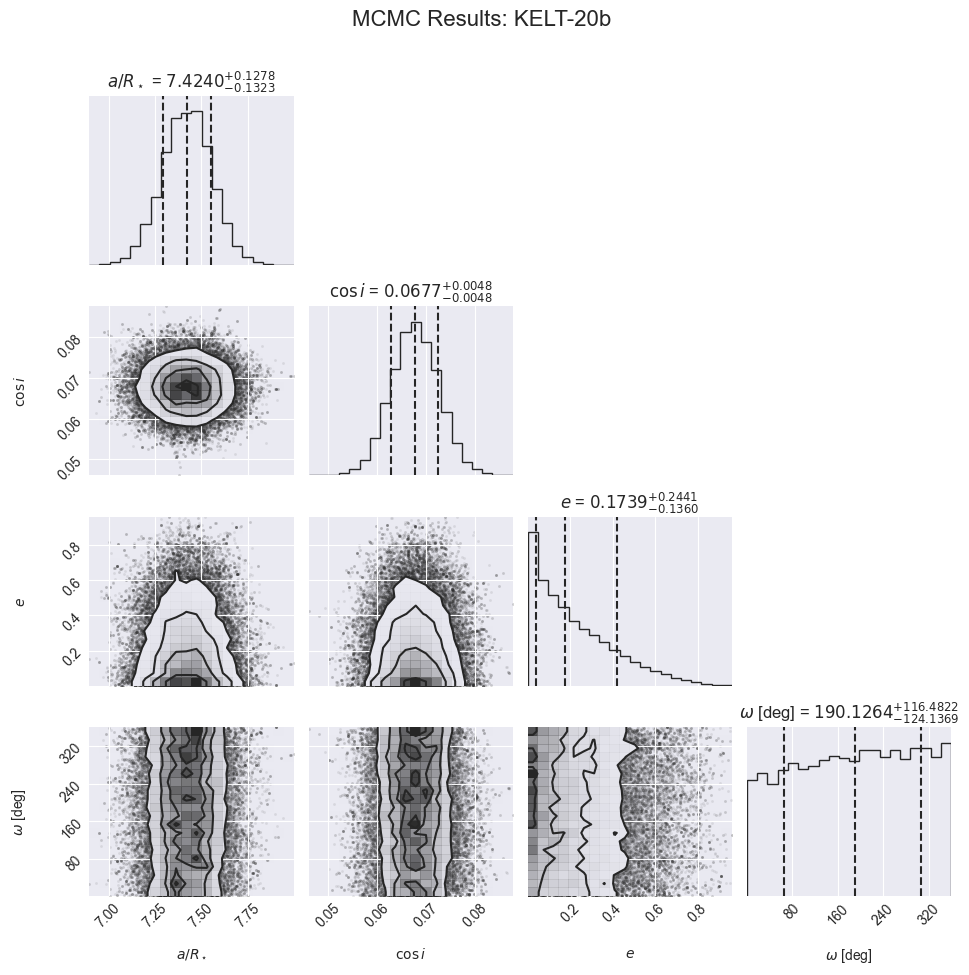

In [10]:
# Plot corner plot for the first system
if len(mcmc_results) > 0:
    result = mcmc_results[0]
    
    labels = [r'$a/R_\star$', r'$\cos i$', r'$e$', r'$\omega$ [deg]']
    
    fig = corner.corner(
        result['samples'],
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt='.4f',
        title_kwargs={"fontsize": 12}
    )
    
    fig.suptitle(f"MCMC Results: {result['name']}", fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()

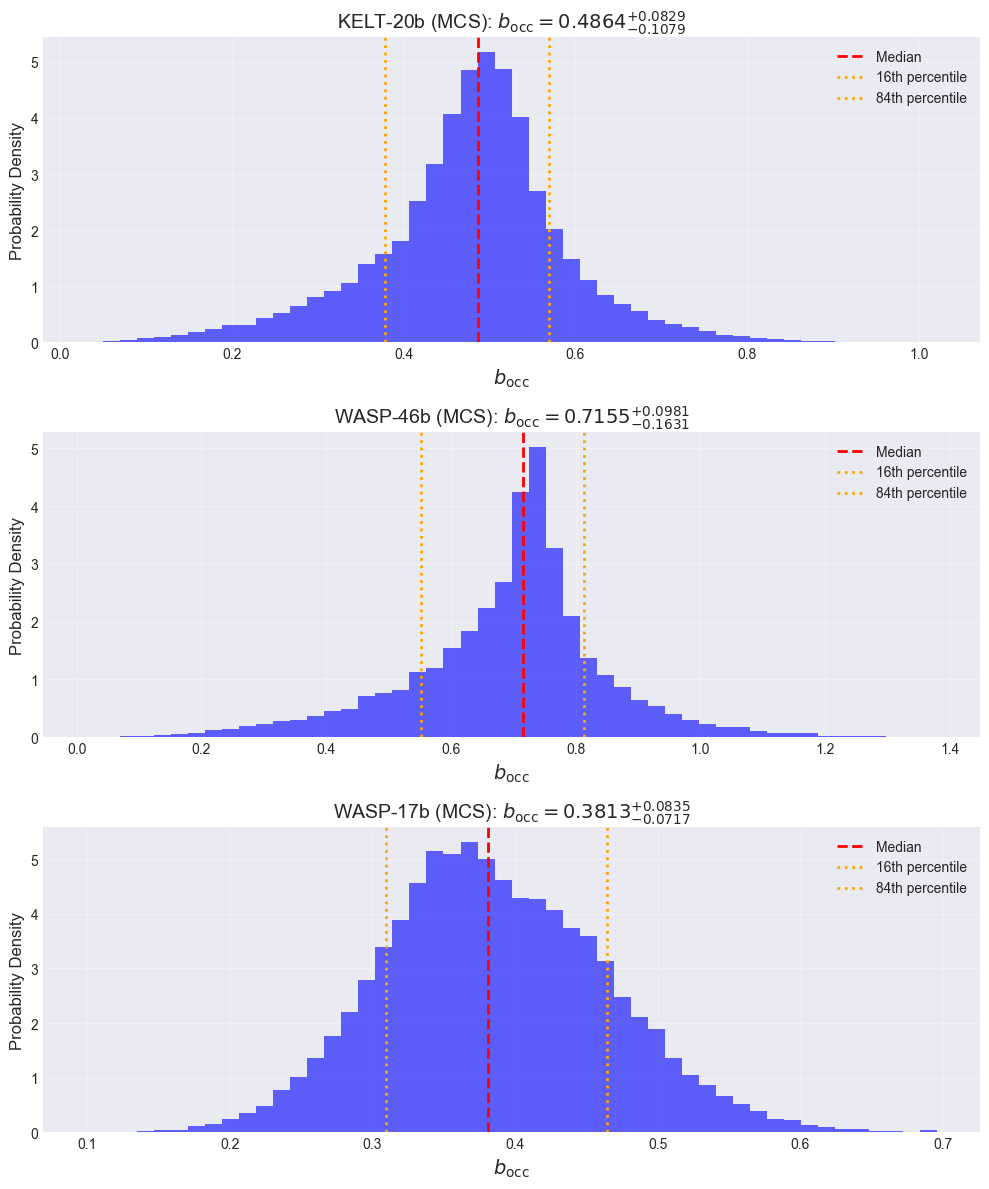

In [11]:
# Plot b_occ distributions for all analyzed systems
if len(mcmc_results) > 0:
    fig, axes = plt.subplots(len(mcmc_results), 1, figsize=(10, 4*len(mcmc_results)))
    
    if len(mcmc_results) == 1:
        axes = [axes]
    
    for i, result in enumerate(mcmc_results):
        ax = axes[i]
        
        # Histogram of b_occ
        ax.hist(result['b_occ_samples'], bins=50, density=True, alpha=0.6, color='blue')
        
        # Mark median and percentiles
        ax.axvline(result['b_occ_median'], color='red', linestyle='--', linewidth=2, label='Median')
        ax.axvline(result['b_occ_median'] - result['b_occ_err_lower'], color='orange', linestyle=':', linewidth=2, label='16th percentile')
        ax.axvline(result['b_occ_median'] + result['b_occ_err_upper'], color='orange', linestyle=':', linewidth=2, label='84th percentile')
        
        ax.set_xlabel(r'$b_{\rm occ}$', fontsize=14)
        ax.set_ylabel('Probability Density', fontsize=12)
        ax.set_title(f"{result['name']} ({result['dataset']}): $b_{{\\rm occ}} = {result['b_occ_median']:.4f}^{{+{result['b_occ_err_upper']:.4f}}}_{{-{result['b_occ_err_lower']:.4f}}}$", fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

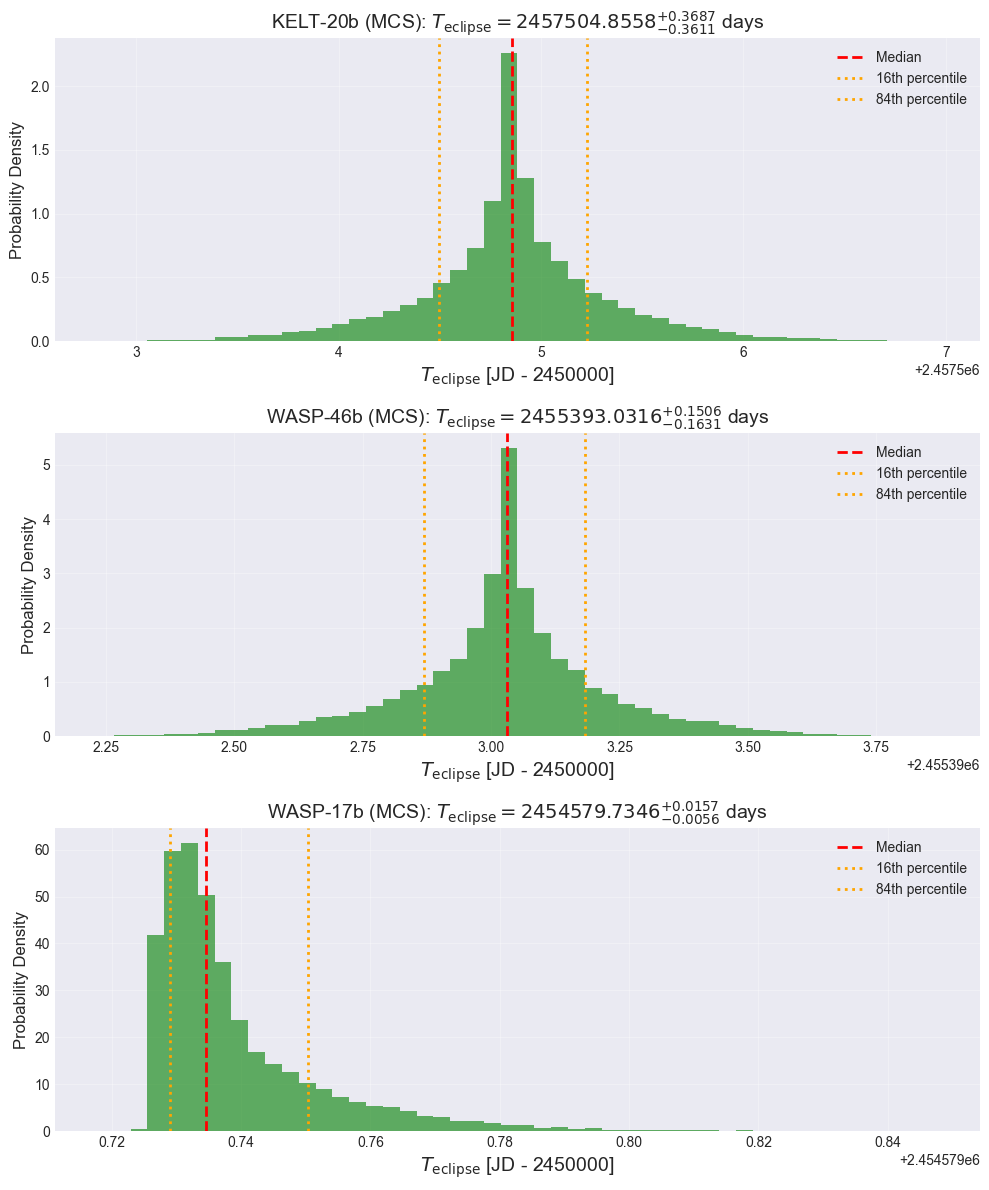

In [12]:
# Plot eclipse midtime (T_eclipse) distributions for all analyzed systems
if len(mcmc_results) > 0:
    fig, axes = plt.subplots(len(mcmc_results), 1, figsize=(10, 4*len(mcmc_results)))
    
    if len(mcmc_results) == 1:
        axes = [axes]
    
    for i, result in enumerate(mcmc_results):
        ax = axes[i]
        
        # Histogram of t_eclipse
        ax.hist(result['t_eclipse_samples'], bins=50, density=True, alpha=0.6, color='green')
        
        # Mark median and percentiles
        ax.axvline(result['t_eclipse_median'], color='red', linestyle='--', linewidth=2, label='Median')
        ax.axvline(result['t_eclipse_median'] - result['t_eclipse_err_lower'], color='orange', linestyle=':', linewidth=2, label='16th percentile')
        ax.axvline(result['t_eclipse_median'] + result['t_eclipse_err_upper'], color='orange', linestyle=':', linewidth=2, label='84th percentile')
        
        ax.set_xlabel(r'$T_{\rm eclipse}$ [JD - 2450000]', fontsize=14)
        ax.set_ylabel('Probability Density', fontsize=12)
        ax.set_title(f"{result['name']} ({result['dataset']}): $T_{{\\rm eclipse}} = {result['t_eclipse_median']:.4f}^{{+{result['t_eclipse_err_upper']:.4f}}}_{{-{result['t_eclipse_err_lower']:.4f}}}$ days", fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Summary Table

Create a summary table of the MCMC results.

In [13]:
# Create summary DataFrame
if len(mcmc_results) > 0:
    summary_data = []
    
    for result in mcmc_results:
        summary_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'Eclipse Observed': result['eclipse_flag'],
            'b_occ (median)': f"{result['b_occ_median']:.4f}",
            'b_occ_err_lower': f"{result['b_occ_err_lower']:.4f}",
            'b_occ_err_upper': f"{result['b_occ_err_upper']:.4f}",
            't_eclipse (median)': f"{result['t_eclipse_median']:.4f}",
            't_eclipse_err_lower': f"{result['t_eclipse_err_lower']:.4f}",
            't_eclipse_err_upper': f"{result['t_eclipse_err_upper']:.4f}",
            'k (Rp/Rs)': f"{result['k']:.4f}",
            '1+k': f"{1+result['k']:.4f}",
            'Acceptance Fraction': f"{result['acceptance_fraction']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

,Planet,Dataset,Eclipse Observed,b_occ (median),b_occ_err_lower,b_occ_err_upper,t_eclipse (median),t_eclipse_err_lower,t_eclipse_err_upper,k (Rp/Rs),1+k,Acceptance Fraction
0,KELT-20b,MCS,True,0.4864,0.1079,0.0829,2457504.8558,0.3611,0.3687,0.1144,1.1144,0.495
1,WASP-46b,MCS,True,0.7155,0.1631,0.0981,2455393.0316,0.1631,0.1506,0.1407,1.1407,0.498
2,WASP-17b,MCS,True,0.3813,0.0717,0.0835,2454579.7346,0.0056,0.0157,0.1302,1.1302,0.521


## 10. Run Full Analysis (Optional)

Uncomment and run this cell to perform MCMC analysis on all systems. 
**Warning: This may take considerable time depending on the number of systems.**

In [ ]:
# Run MCMC on MCS SYSTEMS ONLY - RESUME MODE
import time
import os

print("="*70)
print("PROCESSING MCS SYSTEMS ONLY - RESUME MODE")
print("="*70)
print(f"MCS systems: {len(mcs_systems)}")
print("Note: Skipping TPC systems (focusing on MCS with asymmetric errors)")
print("="*70)

# Output files
mcs_output_file = '../results/mcs_eclipse_mcmc.csv'
mcs_chains_file = '../results/mcs_eclipse_mcmc_chains.npz'
tpc_output_file = '../results/tpc_eclipse_mcmc.csv'
combined_output_file = '../results/eclipse_mcmc_combined.csv'

overall_start_time = time.time()

# ============================================================
# PART 1: Process MCS systems
# ============================================================
print("\nProcessing MCS systems...")

# Load existing results if available (simple resume mode)
mcs_processed_names = set()
mcs_results_list = []
mcs_chains_dict = {}
if os.path.exists(mcs_output_file):
    existing_mcs = pd.read_csv(mcs_output_file)
    mcs_processed_names = set(existing_mcs['Planet'].values)
    mcs_results_list = existing_mcs.to_dict('records')
    print(f"Loaded {len(mcs_processed_names)} existing MCS results")

# Load existing chains if available
if os.path.exists(mcs_chains_file):
    try:
        existing_chains = np.load(mcs_chains_file, allow_pickle=True)
        mcs_chains_dict = dict(existing_chains)
        print(f"Loaded existing chains for {len(mcs_chains_dict)} systems")
    except:
        print(f"⚠️  Warning: Existing NPZ file is corrupted")
        print(f"   Please delete: {mcs_chains_file}")
        print(f"   Then rerun this cell")
        raise RuntimeError("Delete corrupted NPZ file and rerun")

# VALIDATION: Check CSV and NPZ are in sync
csv_exists = os.path.exists(mcs_output_file)
npz_exists = os.path.exists(mcs_chains_file)

if csv_exists and npz_exists:
    # Both exist - verify they match
    csv_names = set(mcs_processed_names)
    npz_names = set(mcs_chains_dict.keys())
    
    if csv_names != npz_names:
        print("\n" + "="*70)
        print("⚠️  ERROR: CSV and NPZ files are OUT OF SYNC!")
        print("="*70)
        print(f"CSV has {len(csv_names)} systems")
        print(f"NPZ has {len(npz_names)} systems")
        
        in_csv_not_npz = csv_names - npz_names
        in_npz_not_csv = npz_names - csv_names
        
        if in_csv_not_npz:
            print(f"\nIn CSV but not NPZ ({len(in_csv_not_npz)} systems):")
            for name in sorted(list(in_csv_not_npz)[:5]):
                print(f"  - {name}")
            if len(in_csv_not_npz) > 5:
                print(f"  ... and {len(in_csv_not_npz) - 5} more")
                
        if in_npz_not_csv:
            print(f"\nIn NPZ but not CSV ({len(in_npz_not_csv)} systems):")
            for name in sorted(list(in_npz_not_csv)[:5]):
                print(f"  - {name}")
            if len(in_npz_not_csv) > 5:
                print(f"  ... and {len(in_npz_not_csv) - 5} more")
        
        print("\n⚠️  ACTION REQUIRED:")
        print("Delete both files and rerun from scratch:")
        print(f"  rm {mcs_output_file}")
        print(f"  rm {mcs_chains_file}")
        print("="*70)
        raise RuntimeError("CSV and NPZ files out of sync - delete both and rerun")
    else:
        print(f"✓ Validation passed: CSV and NPZ both have {len(csv_names)} systems")

elif csv_exists and not npz_exists:
    print("\n" + "="*70)
    print("⚠️  WARNING: CSV exists but NPZ is missing!")
    print("="*70)
    print(f"CSV has {len(mcs_processed_names)} systems but no chains available")
    print("Continuing will create NPZ with only NEW systems")
    print("\n⚠️  RECOMMENDATION: Delete CSV and rerun from scratch to get chains for all systems")
    print(f"  rm {mcs_output_file}")
    print("="*70)
    
elif not csv_exists and npz_exists:
    print("\n" + "="*70)
    print("⚠️  WARNING: NPZ exists but CSV is missing!")
    print("="*70)
    print(f"NPZ has {len(mcs_chains_dict)} systems but no CSV results")
    print("\n⚠️  RECOMMENDATION: Delete NPZ and rerun from scratch")
    print(f"  rm {mcs_chains_file}")
    print("="*70)
    raise RuntimeError("NPZ exists but CSV missing - delete NPZ and rerun")

# Filter to unprocessed systems
mcs_to_process = [s for s in mcs_systems if s['name'] not in mcs_processed_names]
print(f"\nProcessing {len(mcs_to_process)} new MCS systems (skipping {len(mcs_processed_names)} existing)")
print(f"Note: Delete CSV/NPZ files before running to start fresh")

mcs_start_time = time.time()
new_mcs_count = 0

for i, system in enumerate(mcs_to_process, 1):
    try:
        planet_start = time.time()
        
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcs_results_list.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'b_occ_quantiles': ','.join([f"{q:.6f}" for q in result['b_occ_quantiles']]),
            't_eclipse_median': result['t_eclipse_median'],
            't_eclipse_16': result['t_eclipse_16'],
            't_eclipse_84': result['t_eclipse_84'],
            't_eclipse_std': result['t_eclipse_std'],
            't_eclipse_err_lower': result['t_eclipse_err_lower'],
            't_eclipse_err_upper': result['t_eclipse_err_upper'],
            't_eclipse_quantiles': ','.join([f"{q:.6f}" for q in result['t_eclipse_quantiles']]),
            'k_rp_rs': result['k'],
            'one_minus_k': 1 - result['k'],
            'one_plus_k': 1 + result['k'],
            'acceptance_fraction': result['acceptance_fraction']
        })
        
        # Store full MCMC chains
        mcs_chains_dict[result['name']] = {
            'samples': result['samples'],
            'b_occ_samples': result['b_occ_samples'],
            't_eclipse_samples': result['t_eclipse_samples']
        }
        
        new_mcs_count += 1
        
        # Show timing and progress
        planet_time = time.time() - planet_start
        elapsed_total = time.time() - mcs_start_time
        avg_time = elapsed_total / new_mcs_count
        remaining = avg_time * (len(mcs_to_process) - new_mcs_count) / 60
        print(f"✓ MCS [{i}/{len(mcs_to_process)}] {system['name']} - {planet_time:.1f}s (avg: {avg_time:.1f}s, ETA: {remaining:.1f} min)")
        
        # Save checkpoint every 50 NEW systems
        if new_mcs_count % 50 == 0:
            checkpoint_df = pd.DataFrame(mcs_results_list)
            checkpoint_df.to_csv(mcs_output_file, index=False)
            # Save chains checkpoint
            np.savez_compressed(mcs_chains_file, **mcs_chains_dict)
            print(f"  Checkpoint saved: {new_mcs_count} systems (CSV + NPZ chains)")
            
    except Exception as e:
        print(f"\nERROR processing {system['name']}: {e}")
        continue

# Save MCS final results
if len(mcs_results_list) > 0:
    mcs_df = pd.DataFrame(mcs_results_list)
    mcs_df.to_csv(mcs_output_file, index=False)
    
    # Save full MCMC chains
    np.savez_compressed(mcs_chains_file, **mcs_chains_dict)
    
    if new_mcs_count > 0:
        mcs_elapsed = time.time() - mcs_start_time
        print(f"✓ MCS complete: {new_mcs_count} new systems processed in {mcs_elapsed/60:.1f} min ({mcs_elapsed/new_mcs_count:.1f} sec/planet)")
        print(f"  Total MCS results: {len(mcs_results_list)}")
        print(f"  Total chains stored: {len(mcs_chains_dict)}")
    else:
        print(f"✓ MCS: All {len(mcs_results_list)} systems already processed")
        print(f"  Chains available: {len(mcs_chains_dict)}")

# ============================================================
# PART 2: Save results
# ============================================================
if len(mcs_results_list) > 0:
    overall_elapsed = time.time() - overall_start_time
    print("\n" + "="*70)
    print("MCS ANALYSIS COMPLETE")
    print("="*70)
    print(f"Total MCS systems: {len(mcs_results_list)}")
    print(f"New systems processed: {new_mcs_count}")
    print(f"Total time: {overall_elapsed/60:.1f} min")
    print("="*70)
    print(f"\nResults saved to:")
    print(f"  {mcs_output_file}")
    print(f"  {mcs_chains_file} (full MCMC chains)")
    print("\nNote: Using asymmetric error bounds and cos(i) constrained to [0,1]")
    print("\nChain storage format:")
    print("  - samples: [N, 4] array of MCMC parameter samples [a/Rs, cos_i, e, ω]")
    print("  - b_occ_samples: [N] array of eclipse impact parameter samples")
    print("  - t_eclipse_samples: [N] array of eclipse midtime samples [JD-2450000]")
    print(f"\nTo load chains: data = np.load('{mcs_chains_file}', allow_pickle=True)")
    print("                chains = data['PLANET_NAME'].item()")

PROCESSING MCS SYSTEMS ONLY - RESUME MODE
MCS systems: 808
Note: Skipping TPC systems (focusing on MCS with asymmetric errors)

Processing MCS systems...
Loaded 150 existing MCS results
Loaded existing chains for 150 systems
Processing 658 new MCS systems (skipping 150 existing)
Note: Delete CSV/NPZ files before running to start fresh
✓ MCS [1/658] TOI-1478b - 10.0s (avg: 10.0s, ETA: 109.6 min)
✓ MCS [2/658] WASP-48b - 6.3s (avg: 8.1s, ETA: 89.1 min)
✓ MCS [3/658] WASP-12b - 6.4s (avg: 7.6s, ETA: 82.6 min)
emcee: Exception while calling your likelihood function:
  params: [1.91584239e+01 1.14329752e-02 8.15226787e-02 2.25394954e+02]
  args: ({'name': 'TOI-771b', 'a_over_rs': 18.9, 'a_over_rs_err_lower': 1.1, 'a_over_rs_err_upper': 1.1, 'b_tra': 0.22, 'inclination': 89.3, 'inclination_err_lower': 0.5, 'inclination_err_upper': 0.5, 'cos_i': 0.012217000835247136, 'cos_i_err_lower': 0.00872599498739815, 'cos_i_err_upper': 0.00872599498739815, 'eccentricity': 0.055, 'eccentricity_err_lower'

Traceback (most recent call last):
  File "/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_30355/2090096573.py", line 186, in log_probability
    lp = log_prior(theta, system)
  File "/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_30355/2090096573.py", line 129, in log_prior
    log_prob += asymmetric_gaussian_logpdf(
  File "/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_30355/2090096573.py", line 35, in asymmetric_gaussian_logpdf
    return norm.logpdf(x, loc=center, scale=err_upper)
  File "/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 2031, in logpdf
    cond1 = self._support_mask(x, *args) & (scale > 0)
  File "/Users/zoutongshen/Librar

KeyboardInterrupt: 

## 11. Load and Display Results

Load the saved MCMC results and display summary statistics. Run this after Cell 10 completes.

## 11.5 Working with Saved Quantiles

Demonstrate how to load and reconstruct the full b_occ distribution from saved quantiles.

LOADING MCS RESULTS
✓ Loaded CSV: 805 MCS systems
✓ Loaded NPZ chains: 805 systems

ECLIPSE MIDTIME UNCERTAINTY STATISTICS

Average T_eclipse uncertainty:
  Mean:   0.470945 days
  Median: 0.307029 days
  Std:    0.909587 days
  Min:    0.000157 days
  Max:    14.883590 days

Asymmetric error statistics:
  Lower error (median): 0.309974 days
  Upper error (median): 0.303696 days

Systems with largest T_eclipse uncertainties:


,Planet,t_eclipse_median,t_eclipse_err_lower,t_eclipse_err_upper,t_eclipse_err_avg
317,TOI-1859b,2.458697e+06,17.244765,12.522414,14.883590
553,HD28109d,2.458398e+06,9.261186,9.043668,9.152427
139,TOI-4600b,2.459791e+06,7.870343,7.471281,7.670812
149,HD28109c,2.458406e+06,6.057439,6.418001,6.237720
574,K2-24c,2.456937e+06,4.286451,4.142197,4.214324



WORST 3 SYSTEMS (Highest b_occ - Least Likely to Have Eclipses)

System details:


,Planet,b_occ_median,b_occ_err_lower,b_occ_err_upper,one_plus_k,t_eclipse_median,t_eclipse_err_avg,acceptance_fraction
22,TOI-1898b,1.879022,0.445128,0.451705,1.053399,NaN,NaN,0.594948
373,TOI-677b,1.813798,0.111242,0.105647,1.094040,2.458925e+06,0.180546,0.593354
21,TOI-4914b,1.699580,0.115105,0.111299,1.118000,NaN,NaN,0.590792



VISUALIZING b_occ DISTRIBUTIONS FOR WORST 3 SYSTEMS


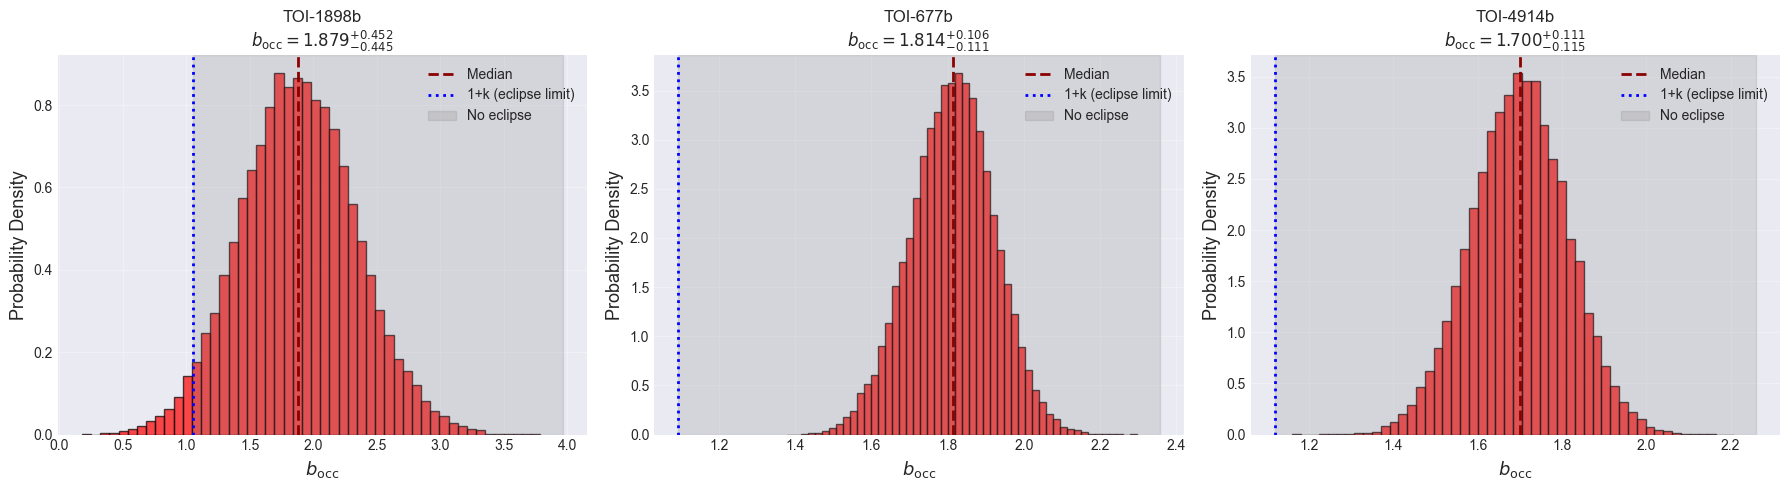


ECLIPSE PROBABILITY FOR WORST 3 SYSTEMS
TOI-1898b: 3.3% chance of observable eclipse
TOI-677b: 0.0% chance of observable eclipse
TOI-4914b: 0.0% chance of observable eclipse

ANALYSIS COMPLETE
CSV file: ../results/mcs_eclipse_mcmc.csv
NPZ file: ../results/mcs_eclipse_mcmc_chains.npz


In [ ]:
# Load and display the MCMC results from Cell 10
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
mcs_csv_file = '../results/mcs_eclipse_mcmc.csv'
mcs_chains_file = '../results/mcs_eclipse_mcmc_chains.npz'

# ============================================================
# LOAD RESULTS
# ============================================================
if os.path.exists(mcs_csv_file):
    print("="*70)
    print("LOADING MCS RESULTS")
    print("="*70)
    mcs_df = pd.read_csv(mcs_csv_file)
    print(f"✓ Loaded CSV: {len(mcs_df)} MCS systems")
    
    # Load chains if available
    chains_available = False
    if os.path.exists(mcs_chains_file):
        chains_data = np.load(mcs_chains_file, allow_pickle=True)
        print(f"✓ Loaded NPZ chains: {len(chains_data.files)} systems")
        chains_available = True
    else:
        print("✗ NPZ chains file not found")
    
    # ============================================================
    # SUMMARY STATISTICS
    # ============================================================
    print("\n" + "="*70)
    print("ECLIPSE MIDTIME UNCERTAINTY STATISTICS")
    print("="*70)
    
    if 't_eclipse_err_lower' in mcs_df.columns:
        # Compute total uncertainty (average of asymmetric errors)
        mcs_df['t_eclipse_err_avg'] = (mcs_df['t_eclipse_err_lower'] + mcs_df['t_eclipse_err_upper']) / 2
        
        print(f"\nAverage T_eclipse uncertainty:")
        print(f"  Mean:   {mcs_df['t_eclipse_err_avg'].mean():.6f} days")
        print(f"  Median: {mcs_df['t_eclipse_err_avg'].median():.6f} days")
        print(f"  Std:    {mcs_df['t_eclipse_err_avg'].std():.6f} days")
        print(f"  Min:    {mcs_df['t_eclipse_err_avg'].min():.6f} days")
        print(f"  Max:    {mcs_df['t_eclipse_err_avg'].max():.6f} days")
        
        print(f"\nAsymmetric error statistics:")
        print(f"  Lower error (median): {mcs_df['t_eclipse_err_lower'].median():.6f} days")
        print(f"  Upper error (median): {mcs_df['t_eclipse_err_upper'].median():.6f} days")
        
        # Systems with largest uncertainties
        print(f"\nSystems with largest T_eclipse uncertainties:")
        largest_uncert = mcs_df.nlargest(5, 't_eclipse_err_avg')[['Planet', 't_eclipse_median', 
                                                                     't_eclipse_err_lower', 't_eclipse_err_upper', 
                                                                     't_eclipse_err_avg']]
        display(largest_uncert)
    
    # ============================================================
    # WORST 3 SYSTEMS (HIGHEST b_occ)
    # ============================================================
    print("\n" + "="*70)
    print("WORST 3 SYSTEMS (Highest b_occ - Least Likely to Have Eclipses)")
    print("="*70)
    
    # Get the 3 systems with highest b_occ
    worst_3 = mcs_df.nlargest(3, 'b_occ_median')
    print("\nSystem details:")
    display(worst_3[['Planet', 'b_occ_median', 'b_occ_err_lower', 'b_occ_err_upper', 
                      'one_plus_k', 't_eclipse_median', 't_eclipse_err_avg', 'acceptance_fraction']])
    
    # ============================================================
    # VISUALIZE WORST 3 SYSTEMS
    # ============================================================
    if chains_available:
        print("\n" + "="*70)
        print("VISUALIZING b_occ DISTRIBUTIONS FOR WORST 3 SYSTEMS")
        print("="*70)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, (i, row) in enumerate(worst_3.iterrows()):
            planet_name = row['Planet']
            ax = axes[idx]
            
            # Load chain for this planet
            if planet_name in chains_data.files:
                chain = chains_data[planet_name].item()
                b_occ_samples = chain['b_occ_samples']
                
                # Plot histogram
                ax.hist(b_occ_samples, bins=50, density=True, alpha=0.7, color='red', edgecolor='black')
                
                # Mark median and 1+k threshold
                ax.axvline(row['b_occ_median'], color='darkred', linestyle='--', linewidth=2, label='Median')
                ax.axvline(row['one_plus_k'], color='blue', linestyle=':', linewidth=2, label='1+k (eclipse limit)')
                
                # Shade region where eclipses are impossible (b_occ > 1+k)
                xlim = ax.get_xlim()
                ax.axvspan(row['one_plus_k'], xlim[1], alpha=0.2, color='gray', label='No eclipse')
                
                ax.set_xlabel(r'$b_{\rm occ}$', fontsize=13)
                ax.set_ylabel('Probability Density', fontsize=13)
                ax.set_title(f"{planet_name}\n$b_{{\\rm occ}} = {row['b_occ_median']:.3f}^{{+{row['b_occ_err_upper']:.3f}}}_{{-{row['b_occ_err_lower']:.3f}}}$", 
                            fontsize=12)
                ax.legend(fontsize=10)
                ax.grid(alpha=0.3)
            else:
                ax.text(0.5, 0.5, f'Chain not found\nfor {planet_name}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_xlabel(r'$b_{\rm occ}$', fontsize=13)
        
        plt.tight_layout()
        plt.show()
        
        # Probability of eclipse for worst 3
        print("\n" + "="*70)
        print("ECLIPSE PROBABILITY FOR WORST 3 SYSTEMS")
        print("="*70)
        for idx, (i, row) in enumerate(worst_3.iterrows()):
            planet_name = row['Planet']
            if planet_name in chains_data.files:
                chain = chains_data[planet_name].item()
                b_occ_samples = chain['b_occ_samples']
                
                # Calculate fraction of samples with b_occ <= 1+k
                eclipse_prob = np.sum(b_occ_samples <= row['one_plus_k']) / len(b_occ_samples) * 100
                print(f"{planet_name}: {eclipse_prob:.1f}% chance of observable eclipse")
    else:
        print("\n✗ Cannot visualize: NPZ chains file not available")
        print("Using quantiles from CSV instead...")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, (i, row) in enumerate(worst_3.iterrows()):
            planet_name = row['Planet']
            ax = axes[idx]
            
            # Parse quantiles from CSV
            if 'b_occ_quantiles' in row and pd.notna(row['b_occ_quantiles']):
                quantiles = np.array([float(x) for x in row['b_occ_quantiles'].split(',')])
                
                # Plot histogram from quantiles
                ax.hist(quantiles, bins=30, density=True, alpha=0.7, color='red', edgecolor='black')
                
                # Mark median and 1+k threshold
                ax.axvline(row['b_occ_median'], color='darkred', linestyle='--', linewidth=2, label='Median')
                ax.axvline(row['one_plus_k'], color='blue', linestyle=':', linewidth=2, label='1+k (eclipse limit)')
                
                # Shade region where eclipses are impossible
                xlim = ax.get_xlim()
                ax.axvspan(row['one_plus_k'], xlim[1], alpha=0.2, color='gray', label='No eclipse')
                
                ax.set_xlabel(r'$b_{\rm occ}$', fontsize=13)
                ax.set_ylabel('Probability Density', fontsize=13)
                ax.set_title(f"{planet_name}\n$b_{{\\rm occ}} = {row['b_occ_median']:.3f}^{{+{row['b_occ_err_upper']:.3f}}}_{{-{row['b_occ_err_lower']:.3f}}}$", 
                            fontsize=12)
                ax.legend(fontsize=10)
                ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    print(f"CSV file: {mcs_csv_file}")
    if chains_available:
        print(f"NPZ file: {mcs_chains_file}")
    print("="*70)
    
else:
    print(f"✗ Results file not found: {mcs_csv_file}")
    print("Run Cell 10 first to generate results.")

In [ ]:
# Check for missing t_eclipse data
if 't_eclipse_median' in mcs_df.columns:
    missing = mcs_df[mcs_df['t_eclipse_median'].isna()]
    print(f"Systems with missing t_eclipse: {len(missing)}")
    if len(missing) > 0:
        print("\nMissing systems:")
        display(missing[['Planet', 'eclipse_observed']])
else:
    print("t_eclipse columns don't exist in CSV - need to re-run Cell 10")

Systems with missing t_eclipse: 156

Missing systems:


,Planet,eclipse_observed
6,TOI-2202b,False
13,WASP-197b,False
15,Kepler-1517b,False
21,TOI-4914b,False
22,TOI-1898b,False
...,...,...
790,TOI-5344b,False
791,TOI-4377b,False
792,HD15337c,False
794,WASP-194b,False


In [ ]:
# TEST: Verify transit_midtime is now populated for previously missing systems
test_planets = ['TOI-2202b', 'WASP-197b', 'Kepler-1517b']
print("Testing transit_midtime population for previously missing systems:")
print("="*70)
for planet in test_planets:
    system = [s for s in mcs_systems if s['name'] == planet]
    if system:
        s = system[0]
        print(f"\n{planet}:")
        print(f"  transit_midtime: {s['transit_midtime']}")
        print(f"  Has data: {'✅ YES' if pd.notna(s['transit_midtime']) else '❌ NO'}")
    else:
        print(f"\n{planet}: Not found in prepared systems")

Testing transit_midtime population for previously missing systems:

TOI-2202b:
  transit_midtime: 2459577.974
  Has data: ✅ YES

WASP-197b:
  transit_midtime: 2456885.104
  Has data: ✅ YES

Kepler-1517b:
  transit_midtime: 2454966.503
  Has data: ✅ YES
